### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.<br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

### WARNING
Please refrain from using **print statements/anything that dumps large outputs(>500 lines) to STDOUT** to avoid running to into **memory issues**. 
Doing so requires your entire lab to be reset which may also result in loss of progress and you will be required to reach out to Coursera for assistance with this.
This process usually takes time causing delays to your submission.

### Validate Button
Please note that this assignment uses nbgrader to facilitate grading. You will see a **validate button** at the top of your Jupyter notebook. If you hit this button, it will run tests cases for the lab that aren't hidden. It is good to use the validate button before submitting the lab. Do know that the labs in the course contain hidden test cases. The validate button will not let you know whether these test cases pass. After submitting your lab, you can see more information about these hidden test cases in the Grader Output. <br>
***Cells with longer execution times will cause the validate button to time out and freeze. Please know that if you run into Validate time-outs, it will not affect the final submission grading.*** <br>

# Module 4: K-nearest neighbors

Run the cell below to ensure that the required packages are imported.

In [66]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# importing all the required libraries

from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Problem 1 : Building a K- Nearest neighbours classifier for handwritten digit recognition [15 pts, Peer Review] 

In this problem you will complete some code to build a k-nearest neighbour classifier to classify images of handwritten digits (0-9). For this purpose we will use a famous open-source dataset of handwritten digits called the MNIST that is ubiquitously used for testing a number of classification algorithms in machine learning.

In [67]:
# This cell sets up the MNIST dataset 

class MNIST_import:
    """
    sets up MNIST dataset from OpenML 
    """
    def __init__(self):
        
        df = pd.read_csv("data/mnist_784.csv")
        
        # Create arrays for the features and the response variable
        # store for use later 
        y = df['class'].values
        X = df.drop('class', axis=1).values
         
        # Convert the labels to numeric labels
        y = np.array(pd.to_numeric(y))
        
        # create training and validation sets 
        self.train_x, self.train_y = X[:5000,:], y[:5000]
        self.val_x, self.val_y = X[5000:6000,:], y[5000:6000]
        
data = MNIST_import()

In [68]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(28,28), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

Display a particular digit using the above function:

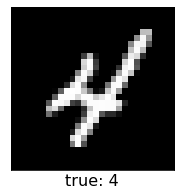

In [69]:
training_index = 9
# your code here
view_digit(data.train_x[training_index], data.train_y[training_index])


**Part 1 [5 points]**
Fill in the code in the following cell to determine the following quantities:
   - Number of pixels in each image
   - Number of examples in the training set
   - Number of examples in the test set
   

In [70]:
# Here are the numbers you need to provide here:
num_training_examples = 0
num_test_examples = 0
pixels_per_image = 0

# your code here
# Determinando o número de exemplos e pixels por imagem
num_training_examples = data.train_x.shape[0] # Número de exemplos de treino
num_test_examples = data.val_x.shape[0] # Número de exemplos de teste
pixels_per_image = data.train_x.shape[1] # Número de pixels por imagem

print(num_training_examples)
print(num_test_examples)
print(pixels_per_image)

5000
1000
784


In [71]:
# tests num_training_exampls, num_test_examples and pixels_per_image

Now that we have our MNIST data in the right form, let us move on to building our KNN classifier.

**Part 2 [10 points]**: Modify the class above to implement a KNN classifier.  There are three methods that you need to complete: 

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples each with $p$ features, return a length-$m$ vector of predicted labels by calling the `classify` function on each example. 
- `classify`: Given a single query example with $p$ features, return its predicted class label as an integer using KNN by calling the `majority` function. 
- `majority`: Given an array of indices into the training set corresponding to the $K$ training examples that are nearest to the query point, return the majority label as an integer.  If there is a tie for the majority label using $K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$ until there is a winning label. 

**Notes**: 
- Don't even think about implementing nearest-neighbor search or any distance metrics yourself.  Instead, go read the documentation for Scikit-Learn's [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You will find that its implemented [query](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query) method can do most of the heavy lifting for you. 
- Do not use Scikit-Learn's KNeighborsClassifier in this problem.  We're implementing this ourselves. 
- Use the visible test cases to validate your code. 

In [72]:
from collections import Counter
from sklearn.neighbors import BallTree
import numpy as np

class KNN:
    """
    Classificador K-Nearest Neighbors (KNN) implementado manualmente.
    """

    def __init__(self, x_train, y_train, K=5):
        """
        Inicializa a instância do kNN.

        :param x_train: numpy array com shape (n_samples, n_features).
        :param y_train: numpy array com shape (n_samples,).
        :param K: Número de vizinhos a serem considerados na classificação.
        """
        self.x_train = np.array(x_train)  # Garante que os dados são um array numpy
        self.y_train = np.array(y_train)  # Converte os rótulos para array numpy
        self.K = K
        self.balltree = BallTree(self.x_train)  # Construindo a estrutura BallTree para busca eficiente

    def majority(self, neighbor_indices):
        """
        Retorna o rótulo majoritário entre os vizinhos mais próximos.
        Em caso de empate, reduz o número de vizinhos até encontrar um vencedor claro.

        :param neighbor_indices: Índices dos K vizinhos mais próximos.
        :return: Rótulo majoritário como inteiro.
        """
        K_temp = self.K  # Variável temporária para reduzir K em caso de empate
        
        while K_temp > 0:
            labels = self.y_train[neighbor_indices[:K_temp]]  # Obtém os rótulos dos K vizinhos
            count = Counter(labels)  # Conta a frequência dos rótulos
            most_common = count.most_common()  # Obtém os rótulos mais frequentes
            
            # Se houver um vencedor claro, retorna o rótulo
            if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:  
                return most_common[0][0]
            
            # Se houver empate, reduz K_temp para desempate
            K_temp -= 1
            

    def classify(self, x):
        """
        Classifica um único exemplo usando KNN.

        :param x: Ponto de consulta (numpy array de shape (n_features,)).
        :return: Rótulo predito como inteiro.
        """
        dist, indices = self.balltree.query([x], k=self.K)  # Busca os K vizinhos mais próximos
        return self.majority(indices[0])  # Obtém o rótulo majoritário

    def predict(self, X):
        """
        Retorna os rótulos previstos para um conjunto de exemplos.

        :param X: Matriz de exemplos a serem classificados (m, p).
        :return: Vetor de previsões (m,).
        """
        return np.array([self.classify(x) for x in X])  # Classifica cada ponto individualmente
        

In [73]:
# Sample tests for KNN class

import pytest
# set-up
X_train = np.array([[1,6], [6,4], [2,5], [1,3], [2,2], [3,1], [1,5], [2,3], [4,6], [3,5], [6,5], [0,4]])
y_train = np.array([+1, -1, +1, +1, -1, +1, +1, -1, +1, -1, +1, -1])
x = np.array([0,5])

# test k=2,
k2nn = KNN(X_train, y_train, K=2)
assert -1 == pytest.approx(k2nn.classify(x)), "KNN class doesn't perform as expected with two neighbors"


# test k=3
k3nn = KNN(X_train, y_train, K=3) 
assert 1 == pytest.approx(k3nn.classify(x)), "KNN class doesn't perform as expected with three neighbors"


# test 3NN Predict 
X = np.array([[2,5], [5,1]])
k3p = KNN(X_train, y_train, K=3) 
yhat = k3p.predict(X)

# correct labels for the above two points(X).
ytrue = [1, -1]

for yh, yt in zip(yhat, ytrue):
    assert yh == yt, "Look at the predict function in the KNN class."

In [74]:
# tests KNN class


**Part 3 : Checking how well your classifier does**
Use your `KNN` class to perform KNN on the validation data with $K=3$ and do the following: 

- **[Peer Review]** Create a **confusion matrix** (feel free to use the Scikit-Learn [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function). Upload a screenshot or copy of your confusion matrix for this week's Peer Review assignment.<br>
**Note:** your code for this section may cause the Validate button to time out. If you want to run the Validate button prior to submitting, you could comment out the code in this section after completing the Peer Review.

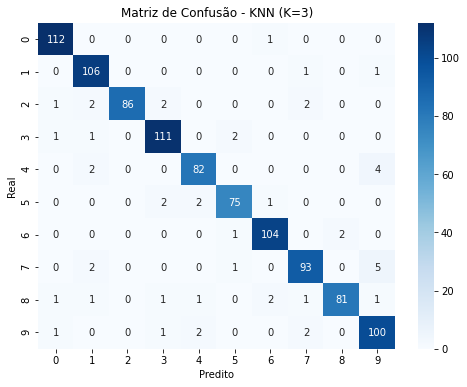

In [75]:
# use your KNN class to perform KNN on the validation data with K = 3
# knn = 
# val_yhat = 

# create a confusion matrix 
# your code here
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o modelo KNN com K = 3
knn = KNN(x_train=data.train_x, y_train=data.train_y, K=3)

# Fazer previsões no conjunto de validação
val_yhat = knn.predict(data.val_x)

# Criar a matriz de confusão
conf_matrix = confusion_matrix(data.val_y, val_yhat)

# Exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - KNN (K=3)")
plt.show()

In [76]:
print(data.val_x.shape)

(1000, 784)


Based on your confusion matrix, which digits seem to get confused with other digits the most? Put your answer in this week's Peer Review assignment.

**Accuracy Plot [Peer Review]**: Create a plot of the accuracy of the KNN on the test set on the same set of axes for  𝐾=1,2,…,20  (feel free to go out to  𝐾=30  if your implementation is efficient enough to allow it). <br>
Upload a copy or screenshot of the plot for this week's Peer Review assignment. <br>
**Note:** your code for this section may cause the Validate button to time out. If you want to run the Validate button prior to submitting, you could comment out the code in this section after completing the Peer Review.

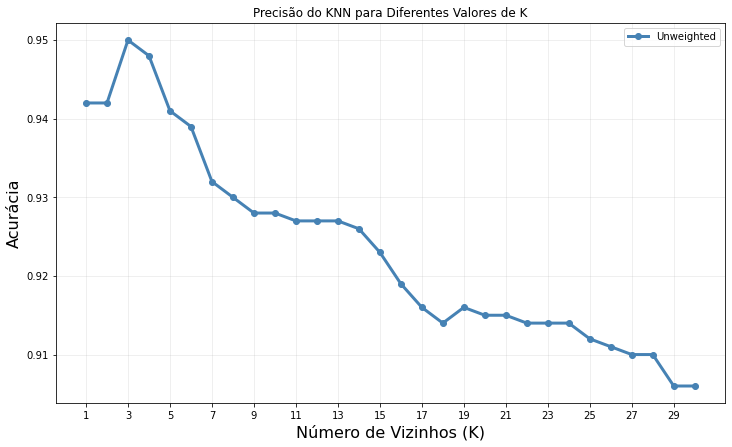

In [78]:

acc = []
wacc = []
allks = range(1,30)

# your code here

# you can use this code to create your plot    
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
# ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
# ax.set_xlabel("number neighbors", fontsize=16)
# ax.set_ylabel("accuracy", fontsize=16)
# plt.xticks(range(1,31,2))
# ax.grid(alpha=0.25)

from sklearn.metrics import accuracy_score

acc = []  # Lista para armazenar as precisões
allks = range(1, 31)  # Valores de K de 1 a 30

for k in allks:
    knn = KNN(x_train=data.train_x, y_train=data.train_y, K=k)  # Criar modelo para cada K
    val_yhat = knn.predict(data.val_x)  # Previsões no conjunto de validação
    accuracy = accuracy_score(data.val_y, val_yhat)  # Calcula a precisão
    acc.append(accuracy)  # Armazena a precisão

# Criar o gráfico
plt.figure(figsize=(12, 7))
plt.plot(allks, acc, marker="o", color="steelblue", lw=3, label="Unweighted")
plt.xlabel("Número de Vizinhos (K)", fontsize=16)
plt.ylabel("Acurácia", fontsize=16)
plt.xticks(range(1, 31, 2))  # Mostrar valores de K em intervalos de 2
plt.title("Precisão do KNN para Diferentes Valores de K")
plt.grid(alpha=0.25)
plt.legend()
plt.show()

Based on the plot, which value of K results in highest accuracy? Answer this question in this week's Peer Review assignment.

### Problem 2: Decision Tree, post-pruning and cost complexity parameter using sklearn 0.22 [10 points, Peer Review]

We will use a pre-processed natural language dataset in the CSV file "spamdata.csv" to classify emails as spam or not. Each row contains the word frequency for 54 words plus statistics on the longest "run" of captial letters.

Word frequency is given by:

$$ f_i = m_i / N $$
Where $f_i$ is the frequency for word $i$, $m_i$ is the number of times word $i$ appears in the email, and $N$ is the total number of words in the email.

We will use decision trees to classify the emails.

**Part A [5 points]:** Complete the function `get_spam_dataset` to read in values from the dataset and split the data into train and test sets.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

def get_spam_dataset(filepath="data/spamdata.csv", test_split=0.1):
    '''
    get_spam_dataset
    
    Loads csv file located at "filepath". Shuffles the data and splits
    it so that the you have (1-test_split)*100% training examples and 
    (test_split)*100% testing examples.
    
    Args:
        filepath: location of the csv file
        test_split: percentage/100 of the data should be the testing split
        
    Returns:
        X_train, X_test, y_train, y_test, feature_names
        Note: feature_names is a list of all column names including isSpam.
        
        (in that order)
        first four are  np.ndarray
        
    '''
    
    # your code here

In [2]:

# TO-DO: import the data set into five variables: X_train, X_test, y_train, y_test, label_names
# Uncomment and edit the line below to complete this task.

test_split = 0.1 # default test_split; change it if you'd like; ensure that this variable is used as an argument to your function
# your code here


In [32]:
# tests X_train, X_test, y_train, y_test, and label_names

**Part B[5 points]** : Build a decision tree classifier using the sklearn toolbox. Then compute metrics for performance like precision and recall. This is a binary classification problem, therefore we can label all points as either positive (SPAM) or negative (NOT SPAM).

In [116]:
def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes =None):
    '''
    This function does the following:
    1. Builds the decision tree classifier using sklearn 
    2. Fits it to the provided data.
    
    
    Arguments
        data_X - a np.ndarray
        data_y - np.ndarray
        max_depth - None if unrestricted, otherwise an integer for the maximum
                depth the tree can reach.
    
    Returns:
        A trained DecisionTreeClassifier
    '''
    
    # your code here
    dt_classifier = DecisionTreeClassifier(
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42
    )
    dt_classifier.fit(data_X, data_y)
    return dt_classifier

In [113]:
# tests build_dt

**Part C [Peer Review]**: Here we are going to use `calculate_precision` and `calculate_recall` functions to see how these metrics change when parameters of the tree are changed.

In [114]:
def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates precision for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    
    
    # Contabilizando os verdadeiros positivos (TP) e falsos positivos (FP)
    true_positives = ((y_true == pos_label_value) & (y_pred == pos_label_value)).sum()
    false_positives = ((y_true != pos_label_value) & (y_pred == pos_label_value)).sum()
    
    # Calculando precisão
    if true_positives + false_positives == 0:
        return 0.0  # Evitar divisão por zero
    precision = true_positives / (true_positives + false_positives)
    
    return precision


def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates recall for a binary classifier.
    
    Args:
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the positive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns recall as a floating point number between 0.0 and 1.0
    '''
    
    # Contabilizando os verdadeiros positivos (TP) e falsos negativos (FN)
    true_positives = ((y_true == pos_label_value) & (y_pred == pos_label_value)).sum()
    false_negatives = ((y_true == pos_label_value) & (y_pred != pos_label_value)).sum()
    
    # Calculando recall
    if true_positives + false_negatives == 0:
        return 0.0  # Evitar divisão por zero
    recall = true_positives / (true_positives + false_negatives)
    
    return recall

In [115]:
# Sample Test cell 
ut_true = np.array([1.0, 1.0, 0.0, 1.0, 1.0, 0.0])
ut_pred = np.array([1.0, 1.0, 1.0, 1.0, 0.0, 1.0])
prec = calculate_precision(ut_true, ut_pred, 1.0)
recall = calculate_recall(ut_true, ut_pred, 1.0)
assert prec == 0.6, "Check the precision value returned from your calculate_precision function."
assert recall == 0.75, "Check the recall value returned from your calculate_recall function."

1. Modifying `max_depth`: 
    - Create a model with a shallow `max_depth` of 2. Build the model on the training set.
    - Report precision/recall on the test set.
    - Report depth of the tree.

In [ ]:
# TODO : Complete the first subtask for max_depth

# your code here


Submit a screenshot of your code for this week's Peer Review assignment. 

2. Modifying `max_leaf_nodes`:
    - Create a model with a shallow `max_leaf_nodes` of 4. Build the model on the training set.
    - Report precision/recall on the test set.
    - Report depth of the tree.

In [ ]:
# TODO : Complete the second subtask for max_depth

# your code here


In your Peer Review answer the following question: <br>
How do precision and recall compare when you modify the max depth compared to the max number of leaf nodes? 
(Make sure to run your models a few times to get an idea). 

**Part D [Peer Review]** : In class, we used gridsearchCV to do hyperparameter tuning to select the different parameters like `max_depth` to see how our tree grows and avoids overfitting. Here, we will use cost complexity pruning parameter $\alpha$ sklearn 0.22.1[https://scikit-learn.org/stable/user_guide.html] to prune our tree after training so as to improve accuracy on unseen data. In this exercise you will iterate over different `ccp_alpha` values and identify how performance is modulated by this parameter. <br>
**Note:** your code for this section may cause the Validate button to time out. If you want to run the Validate button prior to submitting, you could comment out the code in this section after completing the Peer Review.

In [ ]:
dt = build_dt(X_train, y_train)

path = dt.cost_complexity_pruning_path(X_train,y_train) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
# TODO: iterate over ccp_alpha values 
# your code here

    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# TODO: next, generate the train and test scores and plot the variation in these scores with increase in ccp_alpha
# The code for plotting has been provided; edit the train_scores and test_scores variables for the right plot to be generated
train_scores = []
test_scores = []

# your code here


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 
